In [592]:
import pickle

import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy import spatial
from collections import Counter
from torchvision.datasets import Caltech101
from sklearn.model_selection import train_test_split

In [593]:
caltech101 = Caltech101('./caltech101', download=True)

Files already downloaded and verified


In [594]:
def filter_by_category(category: int, max_length: int = 20):
    return [x for x in caltech101 if x[1] == category][:max_length]


def filter_by_categories(categories: list[int], max_length: int = 20):
    return np.concatenate([filter_by_category(c, max_length) for c in categories], dtype='object')

In [595]:
categories = range(1, 21)
dataset = filter_by_categories(categories)

<__array_function__ internals>:180: FutureWarning: The input object of type 'JpegImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'JpegImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [602]:
dataset

array([[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=290x334 at 0x12FA81F4250>,
        1],
       [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=263x332 at 0x12FA814F1F0>,
        1],
       [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=279x308 at 0x12FA81F4520>,
        1],
       [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=261x322 at 0x12FA8FCA4D0>,
        1],
       [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=290x330 at 0x12FA8FCA530>,
        1],
       [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=289x329 at 0x12FA8FC9840>,
        1],
       [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=276x342 at 0x12FA8FCAAA0>,
        1],
       [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=287x335 at 0x12FAD3B4A90>,
        1],
       [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=263x324 at 0x12FAD3B46A0>,
        1],
       [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=264x331 at 0x12FAD3

In [596]:
def dataset_to_df(dataset):
    return pd.DataFrame(dataset, columns=['image', 'category'])

In [597]:
train_dataset, test_dataset = train_test_split(dataset, train_size=.5)
train_df = dataset_to_df(train_dataset)
test_df = dataset_to_df(test_dataset)

In [598]:
def to_gray(img):
    array = np.array(img)
    gray = cv.cvtColor(array, cv.COLOR_BGR2GRAY)
    return gray

In [599]:
def sift(gray_img):
    sift = cv.SIFT_create()
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc


def imshow_key_points(img):
    gray = to_gray(img_ex)
    kp, _ = sift(gray)
    plt.imshow(cv.drawKeypoints(gray, kp, img))
    plt.show()


def get_the_centroids(vector, centroids):
    tree = spatial.KDTree(centroids)
    dist, idxs = tree.query(vector)
    return idxs


def get_bag_of_words(doc, centroids):
    idxs = get_the_centroids(doc, centroids)
    return Counter(idxs), idxs


def elbow(ks, inertias):
    plt.plot(ks, inertias, marker='o')
    plt.title('Elbow method')
    plt.xlabel('Values of k')
    plt.ylabel('Distortion')
    plt.show()


def get_sift_descriptors(dataset):
    descriptors = {}
    key_points = {}
    for img, cls in tqdm(dataset):
        array = np.array(img)
        if len(array.shape) == 3:
            gray = to_gray(img)
        else:
            gray = array
        kp, desc = sift(gray)
        key_points[img.filename] = kp
        descriptors[img.filename] = desc
    return key_points, descriptors

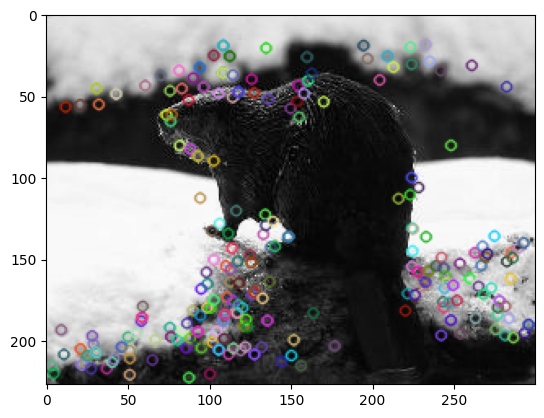

In [600]:
img_ex = train_dataset[0][0]
imshow_key_points(np.array(img_ex))

In [601]:
key_points, descriptors = get_sift_descriptors(dataset)
_, train_descriptors = get_sift_descriptors(train_dataset)
_, test_descriptors = get_sift_descriptors(test_dataset)

400it [00:05, 67.06it/s]
200it [00:03, 56.82it/s]
200it [00:03, 55.97it/s]


In [604]:
ks = range(500, 2000, 100)


def kmeans_clustering(descriptors):
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv.KMEANS_RANDOM_CENTERS
    distortions = {}
    cluster_centroids = {}
    pred_labels = {}
    desc = np.concatenate(list(descriptors.values()))

    for k in ks:
        print(k, end='\r')
        compactness, labels, centers = cv.kmeans(desc, k, None, criteria, 10, flags)
        pred_labels[k] = labels
        cluster_centroids[k] = centers
        dist = np.min(spatial.distance.cdist(desc, centers, 'euclidean'), axis=1)
        distortions[k] = sum(dist / len(desc))

    return cluster_centroids, distortions

In [605]:
train_centroids, train_distortions = kmeans_clustering(train_descriptors)
test_centroids, test_distortions = kmeans_clustering(test_descriptors)

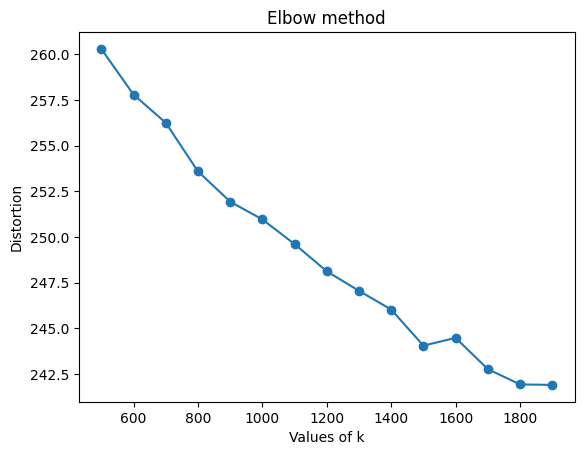

In [606]:
elbow(ks, list(train_distortions.values()))

In [607]:
tfs = []


def get_retrieval_table(dataset, descriptors, train=True):
    occurrences = []
    for img, cls in tqdm(dataset):
        counts, words = get_bag_of_words(centroids, descriptors[img.filename])

        tf = {}
        for word in set(words):
            tf[word] = counts[word] / len(descriptors[img.filename])

        tfs.append(tf)

        occurrences += counts.values()

        table.append(dict(filename=img.filename,
                          category=cls,
                          train_set=train,
                          bag_of_words=counts))
    number_of_occurrences = Counter(occurrences)
    return number_of_occurrences

In [608]:
centroids = train_centroids[min(train_distortions, key=lambda x: train_distortions[x])]
titles = ['filename', 'category', 'train_set', 'bag_of_words']
table = []
occurrences = []

noc = get_retrieval_table(train_dataset, train_descriptors, train=True)
get_retrieval_table(test_dataset, test_descriptors, train=False)

100%|██████████| 200/200 [00:50<00:00,  3.95it/s]


Counter({19: 346,
         21: 248,
         30: 96,
         25: 160,
         46: 22,
         18: 407,
         6: 3430,
         7: 2837,
         1: 14354,
         11: 1222,
         15: 613,
         26: 156,
         9: 1771,
         24: 196,
         8: 2265,
         33: 77,
         10: 1541,
         17: 462,
         13: 872,
         3: 7845,
         23: 196,
         14: 700,
         5: 4581,
         2: 10602,
         20: 324,
         34: 72,
         27: 150,
         4: 5955,
         16: 483,
         12: 1022,
         28: 115,
         61: 6,
         31: 106,
         41: 31,
         59: 11,
         44: 37,
         49: 17,
         22: 238,
         58: 11,
         39: 29,
         73: 5,
         43: 29,
         153: 1,
         32: 74,
         29: 118,
         35: 68,
         51: 10,
         37: 49,
         53: 26,
         47: 20,
         38: 44,
         62: 8,
         52: 21,
         36: 46,
         88: 6,
         76: 7,
         40: 22,
 

In [609]:
table = pd.DataFrame(table, columns=titles)
pickle.dump(table, open('./bag_of_words_table.sav', 'wb'))

In [587]:
idfs = {}
for i in range(len(centroids)):
    #idfs[i] = np.log(len(tfs)/number_of_occurances[i]) # division by 0 wierd
    idfs[i] = np.log(len(tfs) / (noc[i] + 1)) + 1

In [588]:
tf_idfs = []
for row in tfs:
    vector = {}
    for key in row:
        vector[key] = row[key] * idfs[key]
    tf_idfs.append(vector)

KeyError: 514